In [45]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math

# Walkers with MPI: analysis
It seems like all the six trajectories are jammed together in `HILLS_shared`.

I want to check if a proper reweight is possible. This time I have multiple `COLVAR` files, therefore it seems there are multiple reweights. We must apply the associated reweight factor to each point. For example, if we want to reweight `COLVAR.3`, we must multiply only the fourth point of the `HILLS_shared` file (every six). Alternatively, I can devise a script that performs the reweight over all the trajectories simultaneously. 

To see wheter this reweight is effective I can keep track of the distance between the $\alpha$-C of the coordinant oxygens' residues (because the coordination number is slowly varying). 

  

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2157/2781429570.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_hills = plumed.read_as_pandas("HILLS_shared")


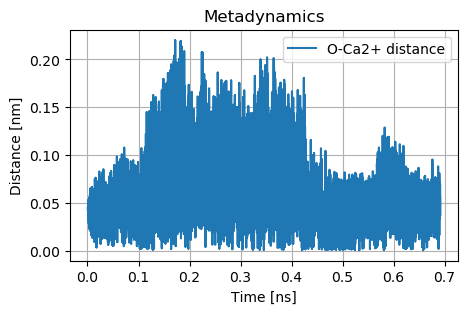

In [3]:
data_hills = plumed.read_as_pandas("HILLS_shared")
plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(data_hills["time"]*0.001, data_hills["d1"], label="O-Ca2+ distance")
plt.xlabel("Time [ns]")
plt.ylabel("Increment of bias potential [kJ/mol]")
plt.grid()
plt.title("Metadynamics")
plt.ylabel("Distance [nm]")
plt.xlabel("Time [ns]")
plt.legend(loc="best")

In [4]:
# Import data from the colvar files
data_colvar0 = plumed.read_as_pandas("COLVAR.0")
data_colvar1 = plumed.read_as_pandas("COLVAR.1")
data_colvar2 = plumed.read_as_pandas("COLVAR.2")
data_colvar3 = plumed.read_as_pandas("COLVAR.3")
data_colvar4 = plumed.read_as_pandas("COLVAR.4")
data_colvar5 = plumed.read_as_pandas("COLVAR.5")

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2157/659377812.py:2: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar0 = plumed.read_as_pandas("COLVAR.0")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2157/659377812.py:3: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar1 = plumed.read_as_pandas("COLVAR.1")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2157/659377812.py:4: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar2 = plumed.read_as_pandas("COLVAR.2")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2157/659377812.py:5: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar3 = plumed.read_as_pandas("COLVAR.3")
/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2157/659377812.py:6: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_colvar4 =

Text(0, 0.5, 'Probability density')

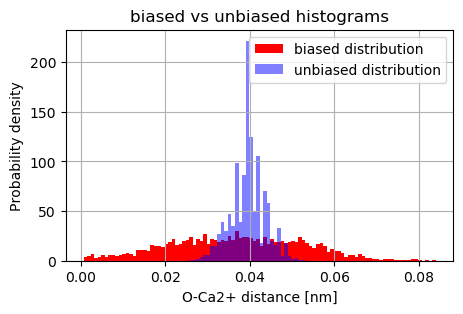

In [13]:
val_bias, bins_bias, patches_bias = plt.hist(data_colvar0["d1"], bins=100, density=True, color='r', label="biased distribution")
kT = 1
w = [math.exp(data_colvar0["metad.rbias"][i])/kT for i in range(len(data_colvar0["metad.rbias"]))]
val_unbias, bins_unbias, patches_unbias = plt.hist(data_colvar0["d1"], bins=100, weights=w, density=True, alpha = 0.5, color= 'b', label="unbiased distribution")
plt.grid()
plt.legend(loc="best")
plt.title("biased vs unbiased histograms")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Probability density")

# Trial with $\alpha$-C distance from Ca2+ ion
Here I collected the distance from `COLVAR.0`. Since `traj_comp.xtc` is computed with a STRIDE=100 by default, we must specify the correct weights from `COLVAR.0`. The `COLVAR.0` is expressed in ps. The quantities are reported every 0.2 ps (=2 fs * 100). On the other hand, the frames of `traj_comp.xtc` are reported every 10 ps. Therefore, we have to store the `metad.rbias` of `COLVAR.0` every 50 samples. 

As a further proof, we can also print the `d1`. It looks like there is some kind of strange numerical effect when the data are recomputed from the `traj.comp.xtc`: the values of the distances are slightly different from the values found in `COLVAR.0`. 


On the other hand, the `HILLS_shared` file samples every 0.8 ps (=2 fs * 400). Remember that for this run we set `PACE=400`. 

Maybe we should perform longer simulation to obtain useful info from `traj.comp`. For instance a trajectory of 8 ns will have 800 points. 

On the other hand, since we have multiple simulations, we can collect values of new functions from all the six `traj.comp.xtc` we have at our disposal. To merge all the files together we can use 
```
cat D2_CA* >> D2_CA_all
```
The negative of this is that we have to take the weights from all the `COLVAR` files. For this reason, we can create a merged `COLVAR_all` file.
 ```
cat COLVAR* >> COLVAR_all
```
We must be careful since each `COLVAR` file could have a number of points (see the time column) which is not a multiple of 50... 

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2157/3353403237.py:1: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_d2 = plumed.read_as_pandas("data/D2_CA_all")


Text(0, 0.5, 'Probability density')

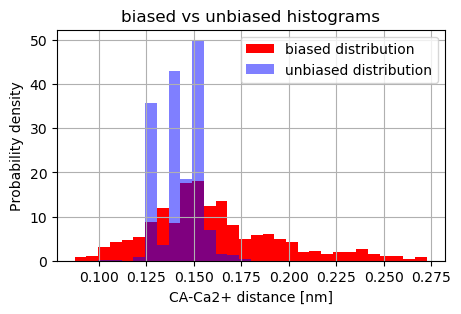

In [52]:
data_d2 = plumed.read_as_pandas("data/D2_CA_all")
val_bias_d2, bins_bias_d2, patches_bias_d2 = plt.hist(data_d2["d2"], bins=30, density=True, color='r', label="biased distribution")


# Compute the weights 
w_d2_0 = [math.exp(data_colvar0["metad.rbias"][i])/kT for i in range(0, len(data_colvar0["metad.rbias"]), 50)]
w_d2_1 = [math.exp(data_colvar1["metad.rbias"][i])/kT for i in range(0, len(data_colvar1["metad.rbias"]), 50)]
w_d2_2 = [math.exp(data_colvar2["metad.rbias"][i])/kT for i in range(0, len(data_colvar2["metad.rbias"]), 50)]
w_d2_3 = [math.exp(data_colvar3["metad.rbias"][i])/kT for i in range(0, len(data_colvar3["metad.rbias"]), 50)]
w_d2_4 = [math.exp(data_colvar4["metad.rbias"][i])/kT for i in range(0, len(data_colvar4["metad.rbias"]), 50)]
w_d2_5 = [math.exp(data_colvar5["metad.rbias"][i])/kT for i in range(0, len(data_colvar5["metad.rbias"]), 50)]

w_d2 = np.concatenate((w_d2_0, w_d2_1, w_d2_2, w_d2_3, w_d2_4, w_d2_5), axis=None)

val_unbias_d2, bins_unbias_d2, patches_unbias_d2 = plt.hist(data_d2["d2"], bins=30, weights=w_d2, density=True, alpha = 0.5, color= 'b', label="unbiased distribution")

plt.grid()
plt.legend(loc="best")
plt.title("biased vs unbiased histograms")
plt.xlabel("CA-Ca2+ distance [nm]")
plt.ylabel("Probability density")

# Reconstruct the profile along the CA-Ca2+ distance

In [25]:
def get_fes(bins, val):
    F = []
    s = []
    mesh = (bins[1] - bins[0])/2
    i = 0
    min = -kT * math.log(val_unbias[0])

    while val[i] != 0 and i<len(val)-1:
        F.append(-kT * math.log(val[i]))
        s.append(bins[i] + mesh)
        if F[i] < min:
            min = F[i]
        i = i + 1

    # Remove the offset
    F = F - min*np.ones(len(F))
    return F, s

Text(0, 0.5, 'Free energy surface')

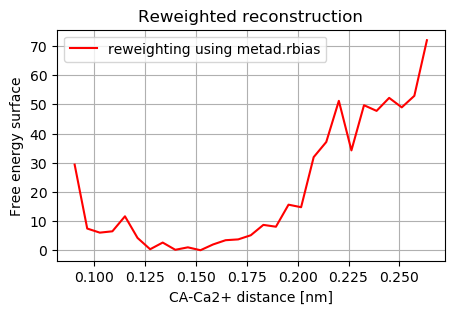

In [53]:
F = []
dist = []
F, dist = get_fes(bins_unbias_d2, val_unbias_d2)

# From the fes.dat file (elaboration of the HILLS file, via sum_hills)
plt.plot(dist, F, 'r',label="reweighting using metad.rbias")
plt.grid()
plt.legend(loc="best")
plt.title("Reweighted reconstruction")
plt.xlabel("CA-Ca2+ distance [nm]")
plt.ylabel("Free energy surface")

/var/folders/hn/315sv5754l3bwzn1_mtrpscc0000gn/T/ipykernel_2157/3125580465.py:5: UserWarning: cannot load PLUMED instance, conversions will not be available
  data_fes = plumed.read_as_pandas("fes.dat")


Text(0, 0.5, 'Free energy surface')

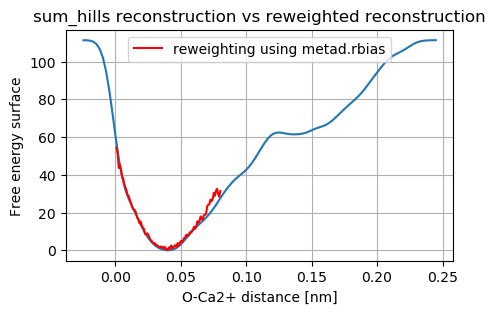

In [28]:
F = []
dist = []
F, dist = get_fes(bins_unbias, val_unbias)

data_fes = plumed.read_as_pandas("fes.dat")
plt.plot(data_fes["d1"], data_fes["file.free"])

# From the fes.dat file (elaboration of the HILLS file, via sum_hills)
plt.plot(dist, F, 'r',label="reweighting using metad.rbias")
plt.grid()
plt.legend(loc="best")
plt.title("sum_hills reconstruction vs reweighted reconstruction")
plt.xlabel("O-Ca2+ distance [nm]")
plt.ylabel("Free energy surface")

In [29]:
np.max(data_colvar0["d1"])

0.08402799999999999

## Important question about the reconstruction
How does plumed reconstruct the profile in `sum_hills`? We only have data until 0.08 nm and still he manages to go until 0.25 nm. 